In [1]:
# RNN(Long Short-Term Memory, LSTM)

In [72]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
import os
%matplotlib inline

In [73]:
def mergeData():
    SaveFile_Name = 'data.csv'
    file_list = os.listdir('data')
    df = pd.read_csv('data'+'\\'+file_list[0])
    df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False)
    for i in range(1,len(file_list)):
        df = pd.read_csv('data'+'\\'+file_list[i])
        df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False, header=False, mode='a+')

In [74]:
def readData():
    train = pd.read_csv("data.csv")
    return train

In [75]:
def changeYear(data):
    for i in range(0,data.shape[0]):
        Date=data["日期"][i].split('/')
        year,month,date=Date[0],Date[1],Date[2]
        year=str(int(year)+1911)
        data.loc[i,"日期"]=year+'/'+month+'/'+date
    return data

In [76]:
# Augment Features
def augFeatures(data):
  data["日期"] = pd.to_datetime(data["日期"])
  data["年"] = data["日期"].dt.year
  data["月"] = data["日期"].dt.month
  data["日"] = data["日期"].dt.day
  data["第幾日"] = data["日期"].dt.dayofweek
  return data

In [77]:
def manage(data):
    for i in range(0,data.shape[0]):
        if data["漲跌價差"][i]=='X0.00':
            data.loc[i,"漲跌價差"]=str(int(data["收盤價"][i])-int(data["收盤價"][i-1]))
    data=data.drop(["日期"], axis=1)
    data=data.drop(["成交股數"], axis=1)
    data=data.drop(["成交金額"], axis=1)
    data=data.drop(["漲跌價差"], axis=1)
    data=data.drop(["成交筆數"], axis=1)
    data=data.convert_objects(convert_numeric=True)
    return data

In [78]:
from sklearn import preprocessing
def normalize(train):
    train = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train

In [79]:
def buildTrain(train, pastDay=30, futureDay=1):
    X_train, Y_train, Z_train= [], [], []
    X,Y,Z=[],[],[]
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["開盤價"]))
        Z_train.append(np.array(train.iloc[i+pastDay-1:i+pastDay]["開盤價"]))
    X=np.array(X_train)
    Y=np.array(Y_train)
    Z=np.array(Z_train)
    Y=100*((Y-Z)/Z)
    Y_train=[]
    
    for i in range(len(Y)):
        if Y[i]<-1.5:
            Y_train.append(np.array([0]))
        elif -1.5<=Y[i]<-0.5:
            Y_train.append(np.array([1]))
        elif -0.5<=Y[i]<0.4:
            Y_train.append(np.array([2]))
        elif 0.4<=Y[i]<1.4:
            Y_train.append(np.array([3]))
        elif 1.4<=Y[i]<2.5:
            Y_train.append(np.array([4]))
        elif 2.5<=Y[i]<4.3:
            Y_train.append(np.array([5]))
        elif 4.3<=Y[i]:
            Y_train.append(np.array([6]))
    Y=np.array(Y_train)
    
    return X, Y

In [80]:
def shuffle1(X,Y):
  np.random.seed()
  randomList = np.arange(X.shape[0])
  np.random.shuffle(randomList)
  return X[randomList], Y[randomList]

In [81]:
# 將Training Data取一部份當作Validation Data
def splitData(X,Y,rate):
    X_train = X[:-int(X.shape[0]*rate)]

    Y_train = Y[:-int(Y.shape[0]*rate)]
    
    X_val = X[-int(X.shape[0]*rate):]

    Y_val = Y[-int(Y.shape[0]*rate):]
    return X_train, Y_train, X_val, Y_val

In [87]:
def buildModel(shape):
    '''
    model = Sequential()
    model.add(LSTM(10,input_length=shape[1], input_dim=shape[2]))
    model.add(Dense(1,activation='softmax'))
    model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['accuracy'])
    model.summary()
    return model
    '''
    model = Sequential()
    model.add(LSTM(32, input_length=shape[1], input_dim=shape[2], return_sequences=True) )
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.3))
    model.add(Dense(50,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(50,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

In [83]:
import matplotlib.pyplot as plt
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
 
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
 
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
 
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()


In [88]:
from sklearn.utils import shuffle

mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)


temp=train

#train=np.array(train)
train=normalize(train)
#train=pd.DataFrame(train)
#train=train.rename(columns = {0:'開盤價',1:'最高價',2:'最低價',3:'收盤價',4:'年',5:'月',6:'日',7:'第幾日'})

train_x1, train_y1 = buildTrain(train,30,1)
train_x2, train_y2 = buildTrain(temp,30,1)
#train_x1= np.reshape(train_x1, (train_x1.shape[0],train_x1.shape[2]))
#train_x1=normalize(train_x1)
#train_x1= np.reshape(train_x1, (train_x1.shape[0],1,train_x1.shape[1]))

train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)


train_x, train_y = shuffle1(train_x, train_y )
print(train_x)
print(train_y)

train_x, train_y , val_x, val_y = splitData(train_x, train_y , 0.1)


#train_x= np.reshape(train_x, (train_x.shape[0],train_x.shape[2]))
#val_x= np.reshape(val_x, (val_x.shape[0],val_x.shape[2]))

history = LossHistory()
model = buildModel(train_x.shape)




#callback = EarlyStopping(monitor="acc", patience=10, verbose=1, mode="auto")

callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x, train_y, epochs=200, batch_size=128, verbose=2,validation_data=(val_x, val_y), callbacks=[history])



C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # Remove the CWD from sys.path while we load stuff.


[[[ 4.25472252e-03 -1.83819668e-04 -4.45612558e-04 ... -5.17452020e-01
   -2.66085177e-02 -2.24810208e-01]
  [-2.18304572e-03 -6.64376799e-03 -3.08181642e-03 ... -5.17452020e-01
    6.72481559e-03 -2.48102084e-02]
  [-2.18304572e-03 -4.49045188e-03 -6.15738760e-03 ... -5.17452020e-01
    4.00581489e-02  1.75189792e-01]
  ...
  [ 1.49843363e-02  1.05827609e-02  7.02363173e-03 ... -3.35633838e-01
   -3.93275184e-01 -4.24810208e-01]
  [ 1.06924908e-02  8.42944476e-03  1.14173048e-02 ... -3.35633838e-01
   -3.59941851e-01 -2.24810208e-01]
  [ 1.28384135e-02  1.05827609e-02  1.36141414e-02 ... -3.35633838e-01
   -3.26608518e-01 -2.48102084e-02]]

 [[ 1.63053006e-01  1.65621521e-01  1.69589537e-01 ... -6.29065652e-02
    4.73391482e-01 -2.24810208e-01]
  [ 1.67344851e-01  1.74234785e-01  1.71786373e-01 ...  2.80025257e-02
   -4.93275184e-01 -2.48102084e-02]
  [ 1.69490774e-01  1.72081469e-01  1.78376883e-01 ...  2.80025257e-02
   -4.59941851e-01  1.75189792e-01]
  ...
  [ 1.37301933e-01  1.3

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, return_sequences=True, input_shape=(30, 8))`
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 30, 32)            5248      
_________________________________________________________________
dropout_33 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dropout_34 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 50)                3250      
_________________________________________________________________
dropout_35 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 50)                2550      
__________

Epoch 78/200
 - 2s - loss: 1.7380 - acc: 0.2801 - val_loss: 1.7788 - val_acc: 0.2744
Epoch 79/200
 - 2s - loss: 1.7362 - acc: 0.2801 - val_loss: 1.7832 - val_acc: 0.2727
Epoch 80/200
 - 2s - loss: 1.7374 - acc: 0.2785 - val_loss: 1.7770 - val_acc: 0.2711
Epoch 81/200
 - 2s - loss: 1.7372 - acc: 0.2810 - val_loss: 1.7842 - val_acc: 0.2792
Epoch 82/200
 - 2s - loss: 1.7349 - acc: 0.2832 - val_loss: 1.7677 - val_acc: 0.2841
Epoch 83/200
 - 2s - loss: 1.7348 - acc: 0.2805 - val_loss: 1.7656 - val_acc: 0.2873
Epoch 84/200
 - 2s - loss: 1.7365 - acc: 0.2789 - val_loss: 1.7900 - val_acc: 0.2695
Epoch 85/200
 - 2s - loss: 1.7363 - acc: 0.2850 - val_loss: 1.7704 - val_acc: 0.2873
Epoch 86/200
 - 2s - loss: 1.7346 - acc: 0.2749 - val_loss: 1.7845 - val_acc: 0.2744
Epoch 87/200
 - 2s - loss: 1.7362 - acc: 0.2828 - val_loss: 1.7779 - val_acc: 0.2711
Epoch 88/200
 - 2s - loss: 1.7322 - acc: 0.2807 - val_loss: 1.7846 - val_acc: 0.2662
Epoch 89/200
 - 2s - loss: 1.7340 - acc: 0.2845 - val_loss: 1.778

Epoch 174/200
 - 2s - loss: 1.6829 - acc: 0.2913 - val_loss: 1.8506 - val_acc: 0.2760
Epoch 175/200
 - 2s - loss: 1.6827 - acc: 0.2987 - val_loss: 1.8138 - val_acc: 0.2808
Epoch 176/200
 - 2s - loss: 1.6908 - acc: 0.2976 - val_loss: 1.8327 - val_acc: 0.2727
Epoch 177/200
 - 2s - loss: 1.6842 - acc: 0.2911 - val_loss: 1.8179 - val_acc: 0.2549
Epoch 178/200
 - 2s - loss: 1.6843 - acc: 0.3028 - val_loss: 1.8414 - val_acc: 0.2646
Epoch 179/200
 - 2s - loss: 1.6767 - acc: 0.3012 - val_loss: 1.8429 - val_acc: 0.2922
Epoch 180/200
 - 2s - loss: 1.6694 - acc: 0.2991 - val_loss: 1.8381 - val_acc: 0.2776
Epoch 181/200
 - 2s - loss: 1.6783 - acc: 0.2974 - val_loss: 1.8144 - val_acc: 0.2662
Epoch 182/200
 - 2s - loss: 1.6844 - acc: 0.2931 - val_loss: 1.8373 - val_acc: 0.2711
Epoch 183/200
 - 2s - loss: 1.6769 - acc: 0.2992 - val_loss: 1.8426 - val_acc: 0.2760
Epoch 184/200
 - 2s - loss: 1.6785 - acc: 0.2946 - val_loss: 1.8589 - val_acc: 0.2711
Epoch 185/200
 - 2s - loss: 1.6776 - acc: 0.2989 - val

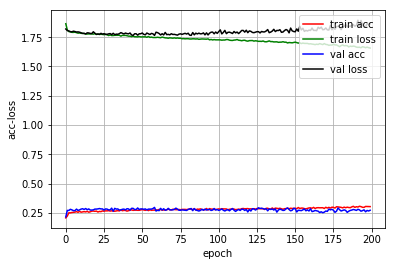

In [89]:
history.loss_plot('epoch')